I wanted to make a Time Series Forecast Analysis of Take-Two Interactive Software, Inc. (TTWO) for the last 10 years (from 6/1/2010 to 5/29/2020) Data taken from https://finance.yahoo.com/

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np


# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Setting default figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


# Forecasting Imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima
from pmdarima.arima import auto_arima


# Math/Error metrics imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
# Loading CSV file with index as date
df = pd.read_csv('finance.yahoo.com-TTWO.csv',index_col='Date',parse_dates= True)
# Dropping columns not needed
TTWO = df.drop(columns= ['Open','High','Low','Close','Volume'])

In [5]:
# Displaying dataframe
TTWO

,Adj Close
Date,
2010-06-01,11.190000
2010-06-02,11.400000
2010-06-03,11.530000
2010-06-04,11.030000
2010-06-07,10.640000
...,...
2020-05-22,140.509995
2020-05-26,130.199997
2020-05-27,134.520004


In [6]:
# Checking if the datetime is index values
TTWO.index

DatetimeIndex(['2010-06-01', '2010-06-02', '2010-06-03', '2010-06-04',
               '2010-06-07', '2010-06-08', '2010-06-09', '2010-06-10',
               '2010-06-11', '2010-06-14',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [7]:
# Aaggregating the data by month (averaging the values by month)
TTWO_weekly =TTWO.resample('W').mean()
# Displaying dataframe
TTWO_weekly

,Adj Close
Date,
2010-06-06,11.287500
2010-06-13,10.300000
2010-06-20,10.194000
2010-06-27,9.724000
2010-07-04,9.172000
...,...
2020-05-03,122.264001
2020-05-10,127.310002
2020-05-17,131.931998


In [8]:
# Aaggregating the data by month (averaging the values by month)
TTWO_monthly =TTWO.resample('M').mean()
# Displaying dataframe
TTWO_monthly

,Adj Close
Date,
2010-06-30,10.192727
2010-07-31,9.862381
2010-08-31,9.000455
2010-09-30,9.656190
2010-10-31,10.411429
...,...
2020-01-31,126.600001
2020-02-29,114.859999
2020-03-31,113.080000


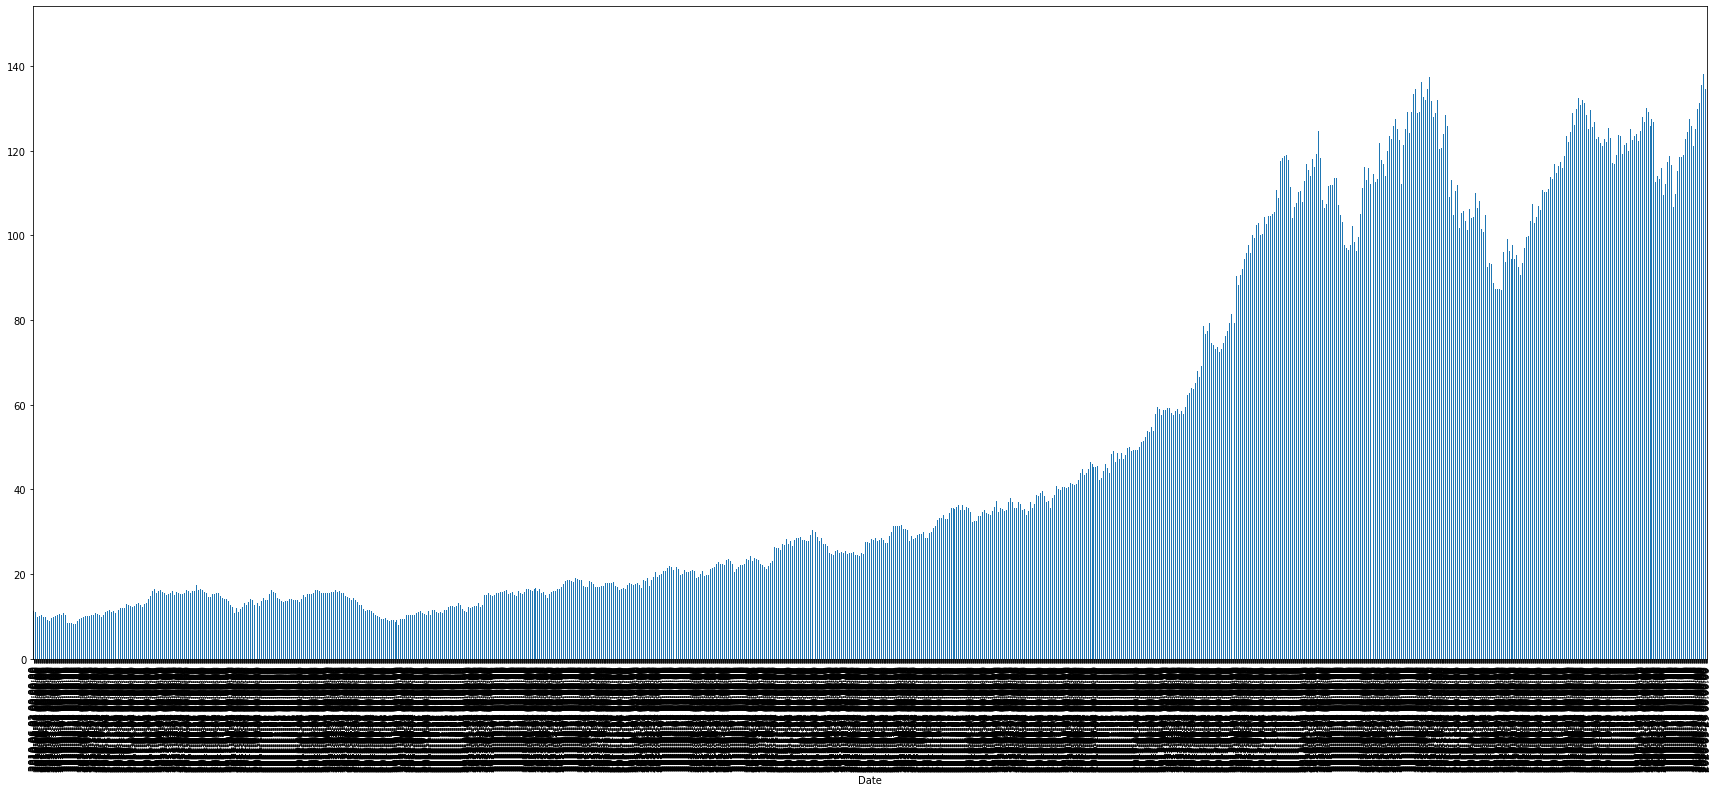

In [22]:
TTWO['Adj Close'].plot.bar(figsize=(30,12))

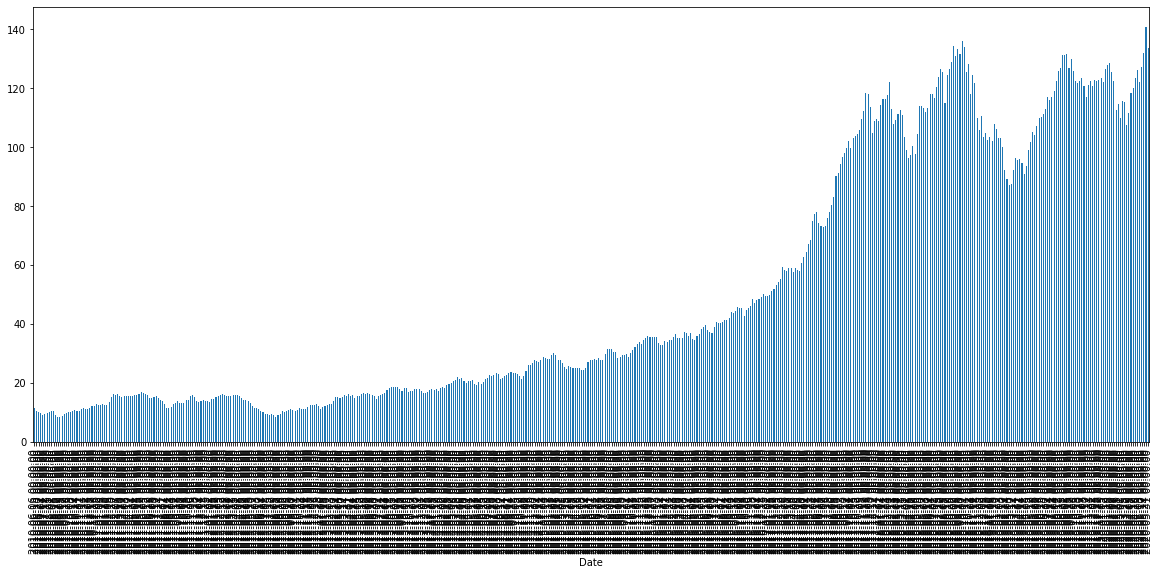

In [10]:
TTWO_weekly['Adj Close'].plot.bar(figsize=(20,8))

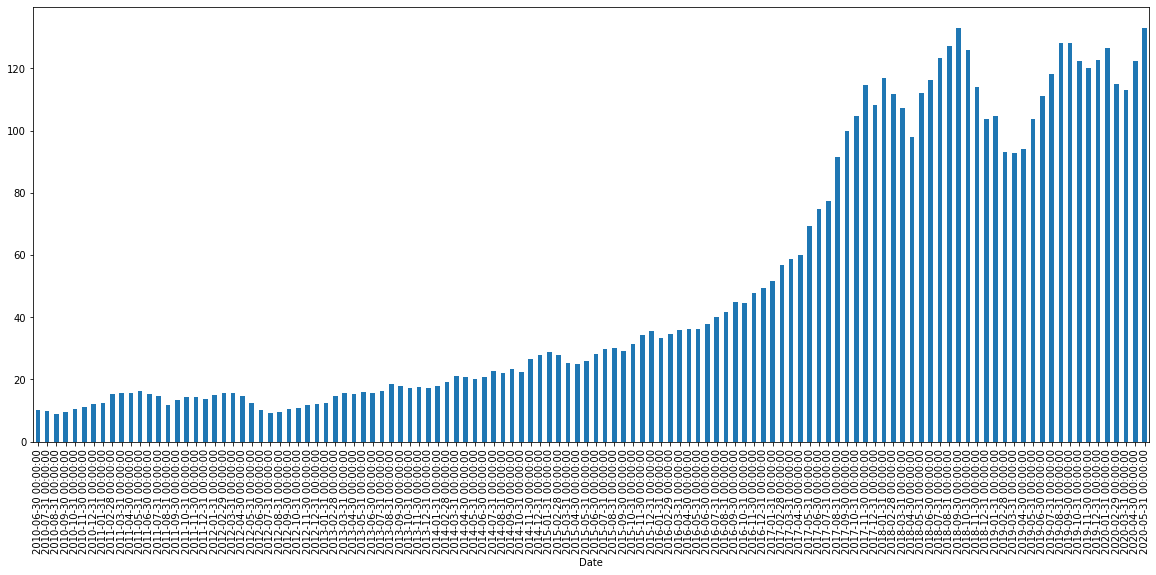

In [11]:
TTWO_monthly['Adj Close'].plot.bar(figsize=(20,8))

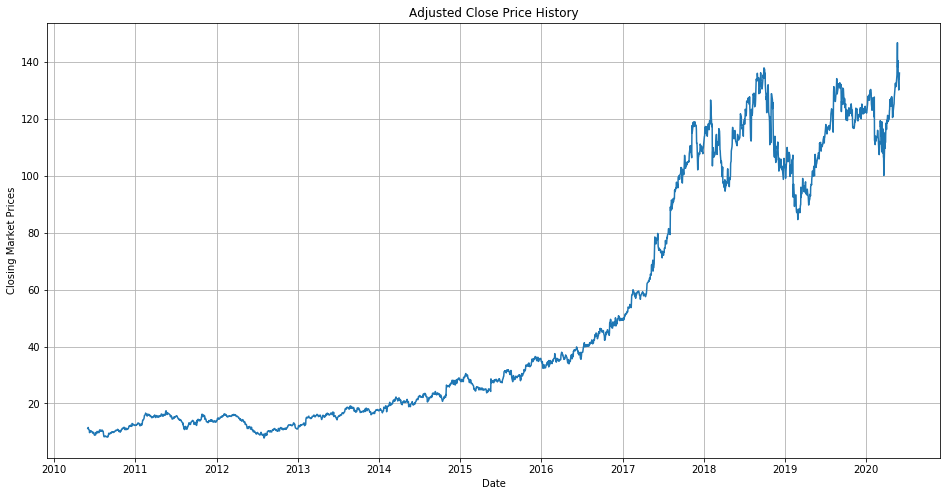

In [12]:
# Plot of Adjusted Close Price history
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Adjusted Close Price History')
plt.plot(TTWO['Adj Close'])
plt.show()

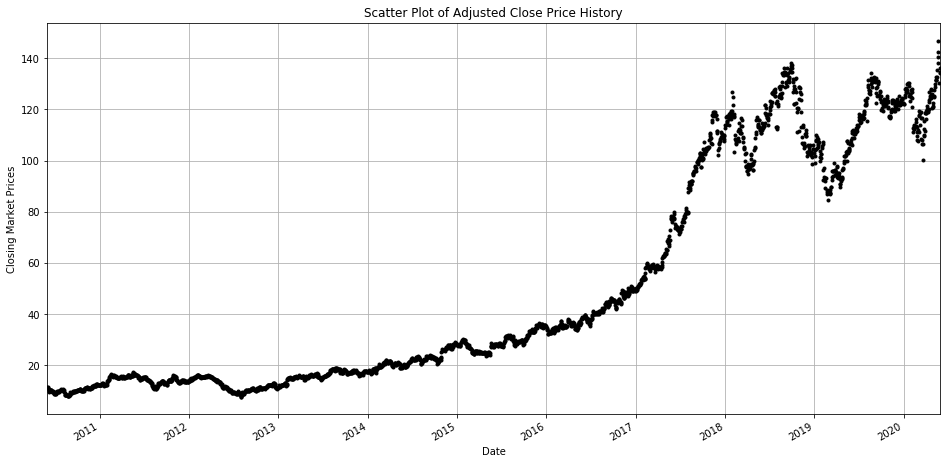

In [19]:
# Scatter Plot of Adjusted Close Price history
plt.figure(figsize=(16,8))
TTWO['Adj Close'].plot(style='k.',)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Scatter Plot of Adjusted Close Price History')
plt.show() 

In [14]:
# Filtering DataFrames to only include dates from 2015
TTWO_filtered = TTWO.loc['2015-01-01':]

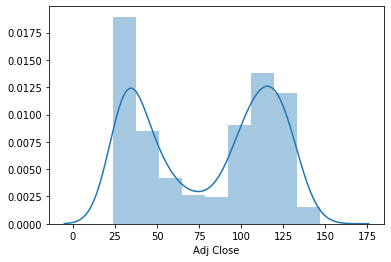

In [15]:
sns.distplot(TTWO_filtered['Adj Close'], hist=True, kde=True)

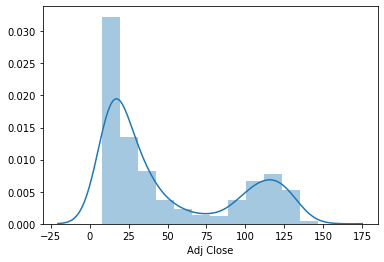

In [16]:
sns.distplot(TTWO['Adj Close'], hist=True, kde=True)

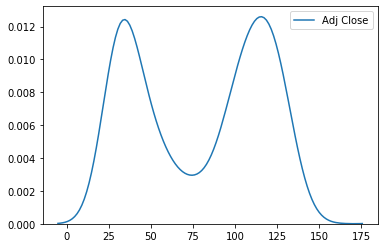

In [17]:
sns.kdeplot(TTWO_filtered['Adj Close'])

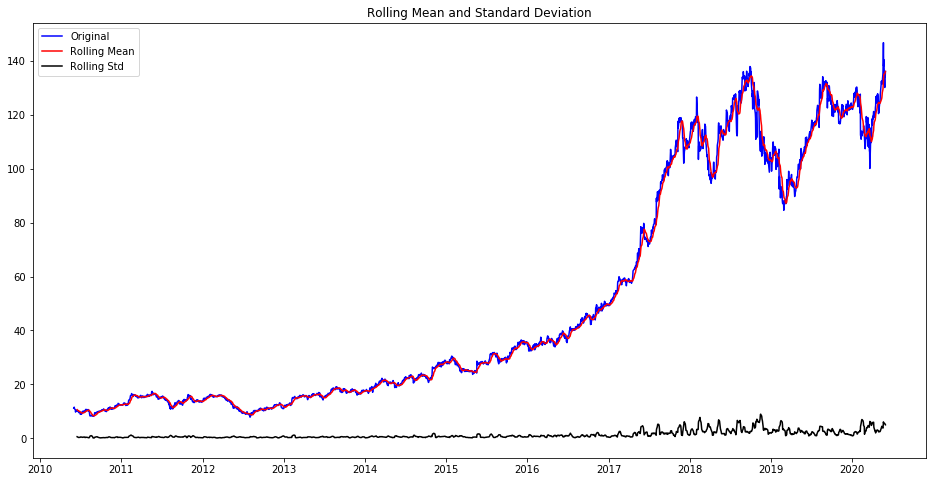

Results of dickey fuller test
Test Statistics                   0.376102
p-value                           0.980579
No. of lags used                 27.000000
Number of observations used    2489.000000
critical value (1%)              -3.432980
critical value (5%)              -2.862702
critical value (10%)             -2.567389
dtype: float64


In [20]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(TTWO['Adj Close'])

C:\Users\sdman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

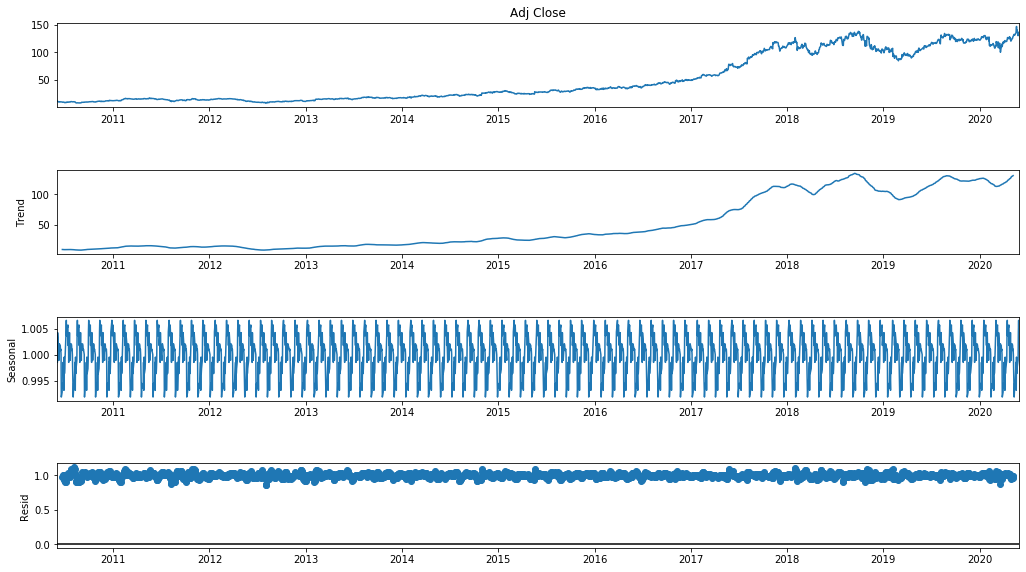

In [21]:
# Separating seasonality and trend
result = seasonal_decompose(TTWO['Adj Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)